In [1]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as np
import numpy as onp
import jax.random as random
import tigercontrol
from tigercontrol.utils.random import set_key, generate_key
from tigercontrol.environments import Environment
from tigercontrol.controllers import Controller
from jax import grad,jit

/Users/johnhallman/mlcourse/mlenv/lib/python3.6/site-packages/jax/lib/xla_bridge.py:120: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
set_key(0) # make everything deterministic

In [3]:
"""
Linear dynamical system
"""


class LDS(Environment):
    """
    Description: The base, master LDS class that all other LDS subenvironments inherit. 
        Simulates a linear dynamical system with a lot of flexibility and variety in
        terms of hyperparameter choices.
    """

    def __init__(self):
        self.initialized = False

    def initialize(self, n, m, noise_distribution=None, noise_magnitude=1.0, A = None, B = None, initial_state = None):
        """
        Description: Randomly initialize the hidden dynamics of the system.
        Args:
            n (int): State dimension.
            m (int): control dimension.
            noise_distribution (None, string, func): if None then no noise. Valid strings include ['normal', 'uniform']. 
                Valid noise functions must map inputs n (x dim), x (state), u (action), w (previous noise), and t (current time)
                to either a scalar or an n-dimensional vector of real values.
            noise magnitude (float): magnitude of noise
            params (dict): specify A, B
            initial_state (None, vector): initial x. If None then randomly initialized
        Returns:
            The first value in the time-series
        """
        self.initialized = True
        self.T = 0
        self.n, self.m = n, m
        self.noise_magnitude = noise_magnitude

        # random normal helper function
        gaussian = lambda dims: random.normal(generate_key(), shape=dims)
        
        self.A = gaussian((n, n))
        self.B = gaussian((n, m))
        
        self.A /= np.linalg.norm(self.A)
        self.B /= np.linalg.norm(self.B)

        # determine the noise function to use, allowing for conditioning on x, u, previous noise, and current t
        if (noise_distribution == None):           # case no noise
            self.noise = lambda n, x, u, w, t: 0.0
        elif (noise_distribution == 'normal'):   # case normal distribution
            self.noise = lambda n, x, u, w, t: gaussian((n,))
        elif (noise_distribution == 'uniform'): # case uniform distribution
            self.noise = lambda n, x, u, w, t: random.uniform(generate_key(), shape=(n,), minval=-1, maxval=1)
        else:                                      # case custom function
            assert callable(noise_distribution), "noise_distribution not valid input" # assert input is callable
            from inspect import getargspec
            arg_sub = getargspec(noise_distribution).args # retrieve all parameters taken by provided function
            for arg in arg_sub:
                assert arg in ['n', 'x', 'u', 'w', 't'], "noise_distribution takes invalid input"
            def noise(n, x, u, w, t):
                noise_args = {'n': n, 'x': x, 'u': u, 'w': w, 't': t}
                arg_dict = {k:v for k,v in noise_args.items() if k in arg_sub}
                return noise_distribution(**arg_dict)
            self.noise = noise

        # initial state
        #self.x = np.zeros(n) if initial_state is None else initial_state
        self.x = gaussian((n,)) if initial_state is None else initial_state
        
        def _step(x, u, eps):
            eps_x = eps
            next_x = np.dot(self.A, x) + np.dot(self.B, u) + self.noise_magnitude * eps_x
            return (next_x, next_x)
        self._step = jax.jit(_step)

        self.prev_noise = np.zeros(n)
        return self.x # return true current state


    def step(self, u):
        """
        Description: Moves the system dynamics one time-step forward.
        Args:
            u (numpy.ndarray): control input, an n-dimensional real-valued vector.
        Returns:
            A new observation from the LDS.
        """
        assert self.initialized
        self.T += 1
        self.prev_noise = self.noise(self.n, self.x, u, self.prev_noise, self.T)
        self.x, y = self._step(self.x, u, self.prev_noise)
        return y # even in fully observable case, y = self.x

In [4]:
n = 3 # dimension of  the state x 
m = 5 # control dimension

problem = LDS()
x = problem.initialize(n, m, noise_distribution = 'normal', noise_magnitude = 0.5)

Q = 0.1 * np.identity(n)
R = 0.1 * np.identity(m)

loss_fn = lambda x, u: x.T @ Q @ x + u.T @ R @ u

In [5]:
class BanditGPC(Controller):
    """
    Description: Computes optimal set of actions using the Linear Quadratic Regulator
    algorithm.
    """

    def __init__(self):
        self.initialized = False

    def initialize(self, A, B, n, m, H, K, delta, x, initial_lr=0.1):
        """
        Description: Initialize the dynamics of the model
        Args:
            A,B (float/numpy.ndarray): system dynamics
            n (float/numpy.ndarray): dimension of the state
            m (float/numpy.ndarray): dimension of the controls
            H (postive int): history of the controller 
            K (float/numpy.ndarray): optimal controller 
            delta (float): gradient estimator parameter
            x (numpy.ndarray): initial state
            initial_lr (float): initial learning rate
        """
        self.initialized = True
        
        def _generate_uniform(shape, norm=1.00):
            v = random.normal(generate_key(), shape=shape)
            v = norm * v / np.linalg.norm(v)
            return v
        self._generate_uniform = _generate_uniform
        self.eps = self._generate_uniform((H, m, n))
        
        self.K = np.zeros ((m,n)) ## compute it...

        self.x = x        
        self.u = np.zeros(m)
        
        self.n = n   ## dimension of  the state x 
        self.m = m   ## dimension of the control u
        self.A = A
        self.B = B
        self.H = H   ## how many control matrices
    
        self.delta = delta

        ## internal parmeters to the class 
        self.T = 1 ## keep track of iterations, for the learning rate
        self.learning_rate = initial_lr
        self.M = self._generate_uniform((H, m, n), norm = 1-delta) ## CANNOT BE SET TO ZERO
        self.w_past = np.zeros((H,n)) ## this are the previous perturbations, from most recent [0] to latest [HH-1]
        
    def get_action(self):
        
        M_tilde = self.M + self.delta * self.eps 
        
        #choose action
        self.u = -K @ self.x
        for i in range(self.H):
            self.u += np.dot(M_tilde[i] , self.w_past[i])
            
        return self.u

    def update(self, c_t, x_new):
        """
        Description: Updates internal parameters and then returns the estimated optimal action (only one)
        Args:
            None
        Returns:
            Estimated optimal action
        """

        self.T += 1
        #self.learning_rate = 1 / self.T**0.75 # eta_t = O(t^(-3/4)) # bug?
        
        #get new noise
        w_new = x_new - np.dot(self.A , self.x)  - np.dot(self.B , self.u)
        
        #update past noises
        self.w_past = np.roll(self.w_past, self.n)
        self.w_past = jax.ops.index_update(self.w_past , 0, w_new)
            
        #set current state
        self.x = x_new
            
        g_t = (self.m * self.n * self.H / self.delta) * c_t * np.sum(self.eps, axis = 0)
        lr = self.learning_rate / self.T**0.75 # eta_t = O(t^(-3/4))
        self.M = (self.M - lr * g_t)
        self.M *= (1-self.delta)/np.linalg.norm(self.M)
        
        return self.u

In [6]:
K = np.zeros((m, n))

T = 1000
H = 8
delta = H **0.75 / T**0.25

model = BanditGPC()
model.initialize(problem.A, problem.B, n, m, H, K, delta, x)

In [7]:
BPC_results = onp.zeros(T)
BPC_regret = onp.zeros(T)
c_t = 0 # cost of initial function is 0
for i in range(T):
    u = model.get_action()
    c_t = loss_fn(x, u)
    x = problem.step(u)
    model.update(c_t, x)
    BPC_results[i] = c_t
    BPC_regret[i] = BPC_regret[-1] * i / (i+1) + c_t /(i+1)

In [8]:
print("start: ", np.mean(np.array(BPC_regret[:10])), "end:", np.mean(np.array((BPC_regret[-10:]))))

start:  0.10217835 end: 0.00016434108


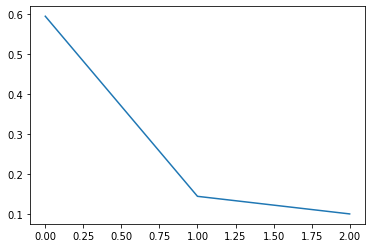

In [9]:
plt.plot(BPC_results[0:3])

In [10]:
x = problem.initialize(n, m, d, noise = 0.2)

X = scipy.linalg.solve_discrete_are(problem.A, problem.B, Q, R)
K = np.linalg.inv(B.T @ X @ B + R) @ (B.T @ X @ A)

LQR_results = []
for i in range(T):
    u = -K @ x
    x = problem.step(u)
    LQR_results.append(x)

NameError: name 'd' is not defined

In [ ]:
plt.plot([np.linalg.norm(i) for i in GPC_results], label = "GPC")
plt.plot([np.linalg.norm(i) for i in LQR_results], label = "LQR")
plt.title("GPC vs. LQR on LDS");
plt.legend();

## Using LQR first to get good initial K estimate

In [ ]:
model = GPC()
model.initialize(problem.A, problem.B, x, n, m, 3, 30, K)